In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns

%matplotlib inline


# Part 1: Read in the data & create the master dataset, unit characteristics

Please note that all datasets were downloaded on January 21, 2023 so analysis may not reflect the present day.   

The first dataset is a list of all residential units, herein defined as condos and rentals (https://opendata.dc.gov/datasets/DCGIS::address-residential-units/about). Note that this does *not* include townhouses and separates out units which have the same address (e.g., 2017 37th Street SE, Apt 102 & 2017 37th Street SE, Apt 201 have the same root address but will be analyzed as separate units). 

For now, the following attributes are worth noting:   
- ADDRESS_ID: ID for a unit's address without unit number, or FULLADDRESS variable; can be shared by more than one entry
- SSL: ID for a unit's address including unit number, or FULL ADDRESS + UNITNUM; unique identifier. Note: Some rows share an SSL, however these are all retired, which I will explain below and will ultimately exclude from analysis.
- UNITTYPE: categorical, either CONDO or RENTAL

In [2]:
addresses = pd.read_csv('Address_Residential_Units.csv')
# Here I am creating a new variable with the full address
addresses['Address'] = addresses.apply(lambda row: str(row.FULLADDRESS) + ' Unit ' + 
                                       str(row.UNITNUM) + ' Washington DC', axis = 1)

full_addresses = addresses['Address']
addresses.head()


,OBJECTID,UNIT_ID,ADDRESS_ID,FULLADDRESS,SSL,STATUS,UNITNUM,UNITTYPE,METADATA_ID,Address
0,1,1271,145743,2017 37TH STREET SE,5671 2022,ACTIVE,102,CONDO,316669,2017 37TH STREET SE Unit 102 Washington DC
1,2,1272,145743,2017 37TH STREET SE,5671 2023,ACTIVE,201,CONDO,316670,2017 37TH STREET SE Unit 201 Washington DC
2,3,1273,145743,2017 37TH STREET SE,5671 2024,ACTIVE,202,CONDO,316671,2017 37TH STREET SE Unit 202 Washington DC
3,4,1274,145743,2017 37TH STREET SE,5671 2025,ACTIVE,301,CONDO,316672,2017 37TH STREET SE Unit 301 Washington DC
4,5,1275,145743,2017 37TH STREET SE,5671 2026,ACTIVE,302,CONDO,316673,2017 37TH STREET SE Unit 302 Washington DC


In [3]:
for col in addresses.columns:
    print(col, addresses[col].isna().sum())

print('Number of residential units in the dataset: ', len(addresses))

OBJECTID 0
UNIT_ID 0
ADDRESS_ID 0
FULLADDRESS 5672
SSL 217649
STATUS 0
UNITNUM 0
UNITTYPE 0
METADATA_ID 0
Address 0
Number of residential units in the dataset:  281002


In [4]:
# I am only interested in condos so I will only keep units of the CONDO UNITTYPE
addresses = addresses[addresses['UNITTYPE'] == 'CONDO']

# The STATUS column can be ACTIVE, RETIRED, or ASSIGNED. I cannot find what ASSIGNED means, but there is only 1
# so I will exclude it from this analysis. I have intuited that RETIRED applies to properties which used to be 
# multiunit and have since been converted to single-family abodes, i.e., townhouses, which are outside of the 
# scope of this analysis. For this reason, I am only keeping units with status ACTIVE.
print('Number of Assigned units: ', len(addresses[addresses['STATUS'] == 'ASSIGNED']))
addresses = addresses[addresses['STATUS'] == 'ACTIVE']

print('Number of addresses: ', len(addresses))
print('Number of unique SSLs: ', len(addresses['SSL'].unique()))

# Finally, I'm dropping columns I don't plan on needing or have already used
addresses = addresses.drop(columns=['OBJECTID', 'UNIT_ID', 'STATUS', 'UNITTYPE', 'UNITNUM', 'METADATA_ID'])
addresses = addresses.rename(columns={"SSL": "SSL_addresses", "ADDRESS_ID":"ADDRESS_ID_addresses"})


Number of Assigned units:  1
Number of addresses:  64965
Number of unique SSLs:  63286


In [5]:
addresses = addresses.dropna(axis=0, subset=['SSL_addresses'])
print('Missing values for addresses dataset:')
for col in addresses.columns:
    print(col, addresses[col].isna().sum())
addresses.head()


Missing values for addresses dataset:
ADDRESS_ID_addresses 0
FULLADDRESS 0
SSL_addresses 0
Address 0


,ADDRESS_ID_addresses,FULLADDRESS,SSL_addresses,Address
0,145743,2017 37TH STREET SE,5671 2022,2017 37TH STREET SE Unit 102 Washington DC
1,145743,2017 37TH STREET SE,5671 2023,2017 37TH STREET SE Unit 201 Washington DC
2,145743,2017 37TH STREET SE,5671 2024,2017 37TH STREET SE Unit 202 Washington DC
3,145743,2017 37TH STREET SE,5671 2025,2017 37TH STREET SE Unit 301 Washington DC
4,145743,2017 37TH STREET SE,5671 2026,2017 37TH STREET SE Unit 302 Washington DC


In [6]:
print('Total active condos: ', len(addresses))


Total active condos:  63285


Preliminarily, we see that there are 63,285 active condos in DC. SSL is a foreign key for other tables so units without these are useless to me, so I remove those.

The next dataset is a list of all *properties* in DC (https://opendata.dc.gov/datasets/DCGIS::address-residential-units/about), which would be equivalent to the ADDRESS_ID in the previous dataset (you'll see below I use this variable to merge the datasets). The following attributes are worth noting:   
- ADDRESS_ID: ID for a unit's address without unit number, or FULLADDRESS variable; unique for every entry.
- SSL: ID for a unit's address including unit number, or FULL ADDRESS + UNITNUM; unique identifier.
- ASSESSMENT_NBHD: categorical, represents different neighborhoods within the city
- ASSESSMENT_SUBNBHD: categorical, sub-categories to the ASSESSMENT_NBDH variable for closer analysis
- WARD: categorical, breaks the city into city council election wards (1-8)
- LATITUDE, LONGITUTDE: numeric, latitude and longitude, will be useful when graphing units
- WARD_2002, WARD_2012: categorical, historical ward data; may be interesting to see if shifts change anything

In [7]:
points = pd.read_csv('Address_Points.csv')
pd.set_option('max_columns', None)
points.head()


/Users/BenBugajski/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,X,Y,SITE_ADDRESS_PK,ADDRESS_ID,ROADWAYSEGID,STATUS,SSL,TYPE_,ENTRANCETYPE,ADDRNUM,ADDRNUMSUFFIX,STNAME,STREET_TYPE,QUADRANT,CITY,STATE,FULLADDRESS,SQUARE,SUFFIX,LOT,NATIONALGRID,ZIPCODE4,XCOORD,YCOORD,STATUS_ID,METADATA_ID,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CFSA_NAME,HOTSPOT,CLUSTER_,POLDIST,ROC,PSA,SMD,CENSUS_TRACT,VOTE_PRCNCT,WARD,ZIPCODE,ANC,NEWCOMMSELECT06,NEWCOMMCANDIDATE,CENSUS_BLOCK,CENSUS_BLOCKGROUP,FOCUS_IMPROVEMENT_AREA,LATITUDE,LONGITUDE,ACTIVE_RES_UNIT_COUNT,RES_TYPE,ACTIVE_RES_OCCUPANCY_COUNT,WARD_2002,WARD_2012,ANC_2002,ANC_2012,SMD_2002,SMD_2012,ANC_2023,SMD_2023,OBJECTID_12,SE_ANNO_CAD_DATA
0,-77.000353,38.892195,27746,27746,11690.0,ACTIVE,0814 0018,ADDRESS,OFFICIAL,402.0,NaN,CONSTITUTION,AVENUE,NE,WASHINGTON,DC,402 CONSTITUTION AVENUE NE,0814,NaN,18,18S UJ 26516 06714,NaN,399969.59,136038.05,1,538259,Capitol Hill,009 C Capitol Hill,South Washington/West of the River Collaborative,NaN,Cluster 25,Police District - First District,Police Sector 1D2,Police Service Area 108,SMD 6C02,8200.0,Precinct 89,Ward 6,20002.0,ANC 6C,NaN,NaN,008200 3001,008200 3,NaN,38.892188,-77.000351,0.0,RESIDENTIAL,1.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,ANC 6C,SMD 6C02,832017,NaN
1,-76.999249,38.892652,50808,50808,3073.0,ACTIVE,0838 0027,ADDRESS,OFFICIAL,219.0,NaN,5TH,STREET,NE,WASHINGTON,DC,219 5TH STREET NE,0838,NaN,27,18S UJ 26613 06763,NaN,400065.35,136088.78,1,96750,Capitol Hill,009 C Capitol Hill,South Washington/West of the River Collaborative,NaN,Cluster 25,Police District - First District,Police Sector 1D2,Police Service Area 108,SMD 6C03,8200.0,Precinct 89,Ward 6,20002.0,ANC 6C,NaN,NaN,008200 3000,008200 3,NaN,38.892645,-76.999247,0.0,RESIDENTIAL,1.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,ANC 6C,SMD 6C03,832018,NaN
2,-76.999769,38.892558,51065,51065,3073.0,ACTIVE,0814 0818,ADDRESS,OFFICIAL,216.0,NaN,5TH,STREET,NE,WASHINGTON,DC,216 5TH STREET NE,0814,NaN,818,18S UJ 26571 06754,NaN,400020.20,136078.30,1,670884,Capitol Hill,009 C Capitol Hill,South Washington/West of the River Collaborative,NaN,Cluster 25,Police District - First District,Police Sector 1D2,Police Service Area 108,SMD 6C02,8200.0,Precinct 89,Ward 6,20002.0,ANC 6C,NaN,NaN,008200 3001,008200 3,NaN,38.892550,-76.999767,1.0,RESIDENTIAL,2.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,ANC 6C,SMD 6C02,832019,NaN
3,-76.999231,38.892546,51219,51219,3073.0,ACTIVE,0838 0041,ADDRESS,OFFICIAL,215.0,NaN,5TH,STREET,NE,WASHINGTON,DC,215 5TH STREET NE,0838,NaN,41,18S UJ 26614 06751,NaN,400066.89,136076.95,1,97092,Capitol Hill,009 C Capitol Hill,South Washington/West of the River Collaborative,NaN,Cluster 25,Police District - First District,Police Sector 1D2,Police Service Area 108,SMD 6C03,8200.0,Precinct 89,Ward 6,20002.0,ANC 6C,NaN,NaN,008200 3000,008200 3,NaN,38.892538,-76.999229,0.0,RESIDENTIAL,1.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,ANC 6C,SMD 6C03,832020,NaN
4,-76.997461,38.892194,3171,3171,9646.0,ACTIVE,0866 0013,ADDRESS,OFFICIAL,626.0,NaN,CONSTITUTION,AVENUE,NE,WASHINGTON,DC,626 CONSTITUTION AVENUE NE,0866,NaN,13,18S UJ 26767 06709,NaN,400220.45,136037.93,1,62301,Capitol Hill,009 C Capitol Hill,South Washington/West of the River Collaborative,NaN,Cluster 25,Police District - First District,Police Sector 1D2,Police Service Area 108,SMD 6C03,8200.0,Precinct 85,Ward 6,20002.0,ANC 6C,NaN,NaN,008200 1001,008200 1,NaN,38.892187,-76.997459,1.0,RESIDENTIAL,2.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,ANC 6C,SMD 6C03,832021,NaN


In [8]:
#pd.reset_option('max_columns')

points = points[['ADDRESS_ID','SSL','ASSESSMENT_NBHD','ENTRANCETYPE', 'ASSESSMENT_SUBNBHD','WARD','LATITUDE',
                 'LONGITUDE', 'QUADRANT', 'VOTE_PRCNCT', 'CENSUS_BLOCK', 'CENSUS_BLOCKGROUP', 'RES_TYPE',
                 'ACTIVE_RES_OCCUPANCY_COUNT','ANC_2002', 'SMD_2002', 'ANC_2012','WARD_2002','WARD_2012',
                'ANC_2023','SMD_2023', 'ZIPCODE']]
points = points.rename(columns = {"SSL":"SSL_points", "ADDRESS_ID":"ADDRESS_ID_points"})

#print('Number of addresses: ', len(points))
#print('Number of unique SSLs: ', len(points['SSL_points'].unique()))
points.head()

,ADDRESS_ID_points,SSL_points,ASSESSMENT_NBHD,ENTRANCETYPE,ASSESSMENT_SUBNBHD,WARD,LATITUDE,LONGITUDE,QUADRANT,VOTE_PRCNCT,CENSUS_BLOCK,CENSUS_BLOCKGROUP,RES_TYPE,ACTIVE_RES_OCCUPANCY_COUNT,ANC_2002,SMD_2002,ANC_2012,WARD_2002,WARD_2012,ANC_2023,SMD_2023,ZIPCODE
0,27746,0814 0018,Capitol Hill,OFFICIAL,009 C Capitol Hill,Ward 6,38.892188,-77.000351,NE,Precinct 89,008200 3001,008200 3,RESIDENTIAL,1.0,ANC 6C,SMD 6C07,ANC 6C,Ward 6,Ward 6,ANC 6C,SMD 6C02,20002.0
1,50808,0838 0027,Capitol Hill,OFFICIAL,009 C Capitol Hill,Ward 6,38.892645,-76.999247,NE,Precinct 89,008200 3000,008200 3,RESIDENTIAL,1.0,ANC 6C,SMD 6C07,ANC 6C,Ward 6,Ward 6,ANC 6C,SMD 6C03,20002.0
2,51065,0814 0818,Capitol Hill,OFFICIAL,009 C Capitol Hill,Ward 6,38.892550,-76.999767,NE,Precinct 89,008200 3001,008200 3,RESIDENTIAL,2.0,ANC 6C,SMD 6C07,ANC 6C,Ward 6,Ward 6,ANC 6C,SMD 6C02,20002.0
3,51219,0838 0041,Capitol Hill,OFFICIAL,009 C Capitol Hill,Ward 6,38.892538,-76.999229,NE,Precinct 89,008200 3000,008200 3,RESIDENTIAL,1.0,ANC 6C,SMD 6C07,ANC 6C,Ward 6,Ward 6,ANC 6C,SMD 6C03,20002.0
4,3171,0866 0013,Capitol Hill,OFFICIAL,009 C Capitol Hill,Ward 6,38.892187,-76.997459,NE,Precinct 85,008200 1001,008200 1,RESIDENTIAL,2.0,ANC 6C,SMD 6C07,ANC 6C,Ward 6,Ward 6,ANC 6C,SMD 6C03,20002.0


In [9]:
pd.set_option("display.max_rows", None)

points['ASSESSMENT_NBHD'].value_counts()

Old City 1                      15745
Old City 2                       8945
Deanwood                         7662
Brookland                        7269
Columbia Heights                 7153
Petworth                         6277
Congress Heights                 5703
Randle Heights                   5136
Chevy Chase                      5047
Brightwood                       4310
Fort Dupont Park                 4136
Georgetown                       4005
Capitol Hill                     4004
Hillcrest                        3667
Trinidad                         3332
Woodridge                        3324
Riggs Park                       2995
Mt. Pleasant                     2610
American University              2564
16th Street Heights              2281
Anacostia                        2268
Lily Ponds                       2202
Eckington                        2187
Bolling Air Force Base           2176
Marshall Heights                 1973
Southwest Waterfront             1804
Ledroit Park

Assessment neighborhood was initially going to be one of my features of interest, however with so many categories and some with as few as 2 condos, I don't know if it will be useful at all. I at least have ward number, which I think will still be useful.

In [10]:
pd.set_option('float_format', '{:f}'.format)
print('Total number of units: ', len(points))
for col in points.columns:
    print(col, points[col].isna().sum())


Total number of units:  149049
ADDRESS_ID_points 0
SSL_points 361
ASSESSMENT_NBHD 77
ENTRANCETYPE 0
ASSESSMENT_SUBNBHD 27636
WARD 0
LATITUDE 0
LONGITUDE 0
QUADRANT 0
VOTE_PRCNCT 0
CENSUS_BLOCK 3
CENSUS_BLOCKGROUP 57
RES_TYPE 0
ACTIVE_RES_OCCUPANCY_COUNT 1
ANC_2002 0
SMD_2002 0
ANC_2012 0
WARD_2002 0
WARD_2012 0
ANC_2023 0
SMD_2023 0
ZIPCODE 20


In [11]:
master1 = pd.merge(left=addresses, right=points, how='left', left_on='ADDRESS_ID_addresses', 
                   right_on='ADDRESS_ID_points')


I choose to merge left onto addresses because that dataset only captures condos while points captures all types of units, both residential and commercial.

In [12]:
print(len(master1))
for col in master1.columns:
    print(col, master1[col].isna().sum())

master1.head()


63285
ADDRESS_ID_addresses 0
FULLADDRESS 0
SSL_addresses 0
Address 0
ADDRESS_ID_points 0
SSL_points 4
ASSESSMENT_NBHD 0
ENTRANCETYPE 0
ASSESSMENT_SUBNBHD 19604
WARD 0
LATITUDE 0
LONGITUDE 0
QUADRANT 0
VOTE_PRCNCT 0
CENSUS_BLOCK 0
CENSUS_BLOCKGROUP 0
RES_TYPE 0
ACTIVE_RES_OCCUPANCY_COUNT 0
ANC_2002 0
SMD_2002 0
ANC_2012 0
WARD_2002 0
WARD_2012 0
ANC_2023 0
SMD_2023 0
ZIPCODE 0


,ADDRESS_ID_addresses,FULLADDRESS,SSL_addresses,Address,ADDRESS_ID_points,SSL_points,ASSESSMENT_NBHD,ENTRANCETYPE,ASSESSMENT_SUBNBHD,WARD,LATITUDE,LONGITUDE,QUADRANT,VOTE_PRCNCT,CENSUS_BLOCK,CENSUS_BLOCKGROUP,RES_TYPE,ACTIVE_RES_OCCUPANCY_COUNT,ANC_2002,SMD_2002,ANC_2012,WARD_2002,WARD_2012,ANC_2023,SMD_2023,ZIPCODE
0,145743,2017 37TH STREET SE,5671 2022,2017 37TH STREET SE Unit 102 Washington DC,145743,5671 0079,Hillcrest,OFFICIAL,028 C Hillcrest,Ward 7,38.863525,-76.953809,SE,Precinct 110,007603 1005,007603 1,RESIDENTIAL,6.000000,ANC 7B,SMD 7B06,ANC 7B,Ward 7,Ward 7,ANC 7B,SMD 7B02,20020.000000
1,145743,2017 37TH STREET SE,5671 2023,2017 37TH STREET SE Unit 201 Washington DC,145743,5671 0079,Hillcrest,OFFICIAL,028 C Hillcrest,Ward 7,38.863525,-76.953809,SE,Precinct 110,007603 1005,007603 1,RESIDENTIAL,6.000000,ANC 7B,SMD 7B06,ANC 7B,Ward 7,Ward 7,ANC 7B,SMD 7B02,20020.000000
2,145743,2017 37TH STREET SE,5671 2024,2017 37TH STREET SE Unit 202 Washington DC,145743,5671 0079,Hillcrest,OFFICIAL,028 C Hillcrest,Ward 7,38.863525,-76.953809,SE,Precinct 110,007603 1005,007603 1,RESIDENTIAL,6.000000,ANC 7B,SMD 7B06,ANC 7B,Ward 7,Ward 7,ANC 7B,SMD 7B02,20020.000000
3,145743,2017 37TH STREET SE,5671 2025,2017 37TH STREET SE Unit 301 Washington DC,145743,5671 0079,Hillcrest,OFFICIAL,028 C Hillcrest,Ward 7,38.863525,-76.953809,SE,Precinct 110,007603 1005,007603 1,RESIDENTIAL,6.000000,ANC 7B,SMD 7B06,ANC 7B,Ward 7,Ward 7,ANC 7B,SMD 7B02,20020.000000
4,145743,2017 37TH STREET SE,5671 2026,2017 37TH STREET SE Unit 302 Washington DC,145743,5671 0079,Hillcrest,OFFICIAL,028 C Hillcrest,Ward 7,38.863525,-76.953809,SE,Precinct 110,007603 1005,007603 1,RESIDENTIAL,6.000000,ANC 7B,SMD 7B06,ANC 7B,Ward 7,Ward 7,ANC 7B,SMD 7B02,20020.000000


The number of units missing sub-NBHD values is high, however the regular NBHD values probably won't be useful so we'll probably delete both anyway. But I'll keep it in for now and do all cleaning at once at the end. Note as well that of the 27,636 sub-NBHD missing values from the address points database, a full 19,604 of these were our condos of interest, suggesting that condos are not often tagged with a sub-NBHD category.

The next dataset is a public dataset for condo appraisal values (https://opendata.dc.gov/datasets/DCGIS::computer-assisted-mass-appraisal-condominium/about). This will be the source of property value, the main variable of interest. The following attributes are worth noting:   
- SSL: ID for a unit's address, including unit number; attribute used for merging with the other datasets
- AYB: Acronym for 'Actual Year Built' (see here: https://otr.cfo.dc.gov/sites/default/files/dc/sites/otr/publication/attachments/Final%20TY2018%20ARM.pdf)
- YR_RMDL: Year unit was remodeled
- EYB: Acronym for 'Effective Year Built', this is when renovations, improvements, or upgrades increase the value of a unit
- ROOMS: Number of rooms
- BEDRM: Number of bedrooms
- BATHRM: Number of full baths
- HF_BATHRM: Number of half baths
- HEAT: Type of heating system
- AC: Yes or no, does the unit have central air
- FIREPLACES: Number of fireplaces
- SALEDATE: Most recent date of sale
- PRICE: Price paid during most recent date of sale
- LIVING_GBA: The square feet of the unit

In [13]:
condo = pd.read_csv('Computer_Assisted_Mass_Appraisal_-_Condominium.csv')
condo.head()

,SSL,BLDG_NUM,CMPLX_NUM,AYB,YR_RMDL,EYB,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,FIREPLACES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,LIVING_GBA,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,OBJECTID
0,0025 2292,1,1782,2006.000000,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Ht Pump,Y,0.000000,2020/01/22 00:00:00+00,1270000.000000,Q,4,1496,17,470,2023/01/20 05:16:51+00,45398605
1,0025 2293,1,1782,2006.000000,2006.000000,2006,5.000000,2.000000,2.000000,0.000000,8.000000,Ht Pump,Y,0.000000,2007/04/30 00:00:00+00,1292250.000000,Q,1,1641,17,530,2023/01/20 05:16:51+00,45398606
2,0025 2294,1,1782,2006.000000,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Ht Pump,Y,0.000000,2022/10/11 00:00:00+00,1400000.000000,Q,4,1152,17,470,2023/01/20 05:16:51+00,45398607
3,0025 2295,1,1782,2006.000000,2006.000000,2006,4.000000,1.000000,2.000000,0.000000,8.000000,Ht Pump,Y,0.000000,2006/10/10 00:00:00+00,659820.000000,Q,1,1161,17,370,2023/01/20 05:16:51+00,45398608
4,0025 2296,1,1782,2006.000000,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Ht Pump,Y,0.000000,2011/03/22 00:00:00+00,700000.000000,Q,1,1047,17,320,2023/01/20 05:16:51+00,45398641


In [14]:
print(len(condo))

condo = condo[['SSL', 'AYB', 'YR_RMDL', 'EYB', 'ROOMS', 'BEDRM', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC',
              'FIREPLACES', 'SALEDATE', 'PRICE', 'LIVING_GBA']]
condo = condo.rename(columns = {'SSL':'SSL_condo', 'AYB':'Actual_Year_Built', 'EYB':'Effective_Year_Built', 
                               'LIVING_GBA':'Living_SqFt', 'PRICE': 'Last_Sale_Price'})

for col in condo.columns:
    print(col, condo[col].isna().sum())


59484
SSL_condo 0
Actual_Year_Built 1
YR_RMDL 23861
Effective_Year_Built 0
ROOMS 508
BEDRM 489
BATHRM 489
HF_BATHRM 596
HEAT 495
AC 493
FIREPLACES 673
SALEDATE 0
Last_Sale_Price 2802
Living_SqFt 0


In [15]:
condo.head()

,SSL_condo,Actual_Year_Built,YR_RMDL,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,SALEDATE,Last_Sale_Price,Living_SqFt
0,0025 2292,2006.000000,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,2020/01/22 00:00:00+00,1270000.000000,1496
1,0025 2293,2006.000000,2006.000000,2006,5.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,2007/04/30 00:00:00+00,1292250.000000,1641
2,0025 2294,2006.000000,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,2022/10/11 00:00:00+00,1400000.000000,1152
3,0025 2295,2006.000000,2006.000000,2006,4.000000,1.000000,2.000000,0.000000,8.000000,Y,0.000000,2006/10/10 00:00:00+00,659820.000000,1161
4,0025 2296,2006.000000,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,2011/03/22 00:00:00+00,700000.000000,1047


In [16]:
master2 = pd.merge(left=condo, right=master1, how='left', left_on='SSL_condo', 
                   right_on='SSL_addresses')
master2.head()

,SSL_condo,Actual_Year_Built,YR_RMDL,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,SALEDATE,Last_Sale_Price,Living_SqFt,ADDRESS_ID_addresses,FULLADDRESS,SSL_addresses,Address,ADDRESS_ID_points,SSL_points,ASSESSMENT_NBHD,ENTRANCETYPE,ASSESSMENT_SUBNBHD,WARD,LATITUDE,LONGITUDE,QUADRANT,VOTE_PRCNCT,CENSUS_BLOCK,CENSUS_BLOCKGROUP,RES_TYPE,ACTIVE_RES_OCCUPANCY_COUNT,ANC_2002,SMD_2002,ANC_2012,WARD_2002,WARD_2012,ANC_2023,SMD_2023,ZIPCODE
0,0025 2292,2006.000000,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,2020/01/22 00:00:00+00,1270000.000000,1496,300365.000000,2425 L STREET NW,0025 2292,2425 L STREET NW Unit 906 Washington DC,300365.000000,0025 0022,Central-tri 1,OFFICIAL,NaN,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000
1,0025 2293,2006.000000,2006.000000,2006,5.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,2007/04/30 00:00:00+00,1292250.000000,1641,300365.000000,2425 L STREET NW,0025 2293,2425 L STREET NW Unit 907 Washington DC,300365.000000,0025 0022,Central-tri 1,OFFICIAL,NaN,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000
2,0025 2294,2006.000000,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,2022/10/11 00:00:00+00,1400000.000000,1152,300365.000000,2425 L STREET NW,0025 2294,2425 L STREET NW Unit 908 Washington DC,300365.000000,0025 0022,Central-tri 1,OFFICIAL,NaN,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000
3,0025 2295,2006.000000,2006.000000,2006,4.000000,1.000000,2.000000,0.000000,8.000000,Y,0.000000,2006/10/10 00:00:00+00,659820.000000,1161,300365.000000,2425 L STREET NW,0025 2295,2425 L STREET NW Unit 230 Washington DC,300365.000000,0025 0022,Central-tri 1,OFFICIAL,NaN,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000
4,0025 2296,2006.000000,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,2011/03/22 00:00:00+00,700000.000000,1047,300365.000000,2425 L STREET NW,0025 2296,2425 L STREET NW Unit 231 Washington DC,300365.000000,0025 0022,Central-tri 1,OFFICIAL,NaN,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000


In [17]:
print(len(master2))

for col in master2.columns:
    print(col, master2[col].isna().sum())
len(master2) - len(condo) + master2['SSL_addresses'].isna().sum()

59484
SSL_condo 0
Actual_Year_Built 1
YR_RMDL 23861
Effective_Year_Built 0
ROOMS 508
BEDRM 489
BATHRM 489
HF_BATHRM 596
HEAT 495
AC 493
FIREPLACES 673
SALEDATE 0
Last_Sale_Price 2802
Living_SqFt 0
ADDRESS_ID_addresses 3012
FULLADDRESS 3012
SSL_addresses 3012
Address 3012
ADDRESS_ID_points 3012
SSL_points 3016
ASSESSMENT_NBHD 3012
ENTRANCETYPE 3012
ASSESSMENT_SUBNBHD 19367
WARD 3012
LATITUDE 3012
LONGITUDE 3012
QUADRANT 3012
VOTE_PRCNCT 3012
CENSUS_BLOCK 3012
CENSUS_BLOCKGROUP 3012
RES_TYPE 3012
ACTIVE_RES_OCCUPANCY_COUNT 3012
ANC_2002 3012
SMD_2002 3012
ANC_2012 3012
WARD_2002 3012
WARD_2012 3012
ANC_2023 3012
SMD_2023 3012
ZIPCODE 3012


3012

Note that I chose to left merge onto *condo* instead of *addresses* like before. This is because the point of this exercise is to model for price based on unit characteristics. My dependent variable is found in this dataset so I choose to use this and get rid of some potential units than to have tons of missing data later on (there are more units in the 'addresses' dataset than 'condo').

The next dataset is composed of tax and appraisal information (https://opendata.dc.gov/datasets/DCGIS::integrated-tax-system-public-extract-facts/about). I unfortunately couldn't find a detailed data dictionary for this table so I'm not able to use the prior or proposed appraisal value or cap; however, the current total appraised value is straightforward enough. A quick comparison with the DC appraisal lookup database (https://mytax.dc.gov/_/) determined that the appraisals are current up through the end of 2022, so my analysis within January, 2023 is still current enough to be useful and accurate. The following variables will be used:   
- SSL: ID for a unit's address, including unit number; attribute used for merging with the other datasets
- APPRAISED_VALUE_CURRENT_TOTAL: unit's total appraisal value, or the city's estimation of worth
- OTR_NEIGHBORHOOD_NAME: The name of the unit's neighborhood
- LAND_USE_DESCRIPTION: qualitative description of the unit
- LAST_SALE_PRICE: last sale price
- LAST_SALE_DATE: last sale date
- TAXRATE: unit tax rate

In [18]:
taxes = pd.read_csv('ITSPE_FACTS_view_6464931457214209052.csv')
taxes.head()

,OBJECTID,SSL,ASSESSOR_NAME,LAND_USE_CODE,LAND_USE_DESCRIPTION,LANDAREA,PROPERTY_ADDRESS,OTR_NEIGHBORHOOD_CODE,OTR_NEIGHBORHOOD_NAME,OWNER_NAME_PRIMARY,CAREOF_NAME,OWNER_ADDRESS_LINE1,OWNER_ADDRESS_LINE2,OWNER_ADDRESS_CITYSTZIP,APPRAISED_VALUE_PRIOR_LAND,APPRAISED_VALUE_PRIOR_IMPR,APPRAISED_VALUE_PRIOR_TOTAL,APPRAISED_VALUE_PROPOSED_LAND,APPRAISED_VALUE_PROPOSED_IMPR,APPRAISED_VALUE_PROPOSED_TOTAL,APPRAISED_VALUE_CURRENT_LAND,APPRAISED_VALUE_CURRENT_BLDG,VACANT_USE,HOMESTEAD_DESCRIPTION,TAX_TYPE_DESCRIPTION,TAXRATE,MIXED_USE,OWNER_OCCUPIED_COOP_UNITS,LAST_SALE_PRICE,LAST_SALE_DATE,DEED_DATE,CURRENT_ASSESSMENT_CAP,PROPOSED_ASSESSMENT_CAP,OWNER_NAME_SECONDARY,ADDRESS_ID,LASTMODIFIEDDATE,APPRAISED_VALUE_CURRENT_TOTAL
0,1,PI0056330168,nan,21.000000,Residential-Apartment-Walk-Up,83883,2560 NAYLOR RD SE WASHINGTON DC 20020,28,Hillcrest,PARK NAYLOR ASSOC. L.P.,NaN,NaN,nan,NaN,0,66550,66550,0,61892,61892,0,61892,NO,NO HOMESTEAD,"Residential real property, including multifamily",0.850000,NaN,0,0,NaN,NaN,61892,61892,NaN,NaN,1/20/2023 6:01:40 AM,61892
1,2,PI0056330171,nan,21.000000,Residential-Apartment-Walk-Up,75114,2520 NAYLOR RD SE WASHINGTON DC 20020,28,Hillcrest,PARK NAYLOR ASSOC. L.P.,NaN,NaN,nan,NaN,0,57060,57060,0,53066,53066,0,53066,NO,NO HOMESTEAD,"Residential real property, including multifamily",0.850000,NaN,0,0,NaN,NaN,53066,53066,NaN,NaN,1/20/2023 6:01:40 AM,53066
2,3,PI0056330167,nan,21.000000,Residential-Apartment-Walk-Up,87266,2576 NAYLOR RD SE WASHINGTON DC 20020,28,Hillcrest,PARK NAYLOR ASSOC. L.P.,NaN,NaN,nan,NaN,0,69230,69230,0,64384,64384,0,64384,NO,NO HOMESTEAD,"Residential real property, including multifamily",0.850000,NaN,0,0,NaN,NaN,64384,64384,NaN,NaN,1/20/2023 6:01:40 AM,64384
3,4,PI0006230382,nan,nan,Not assigned yet,51413,801 NEW JERSEY AVE NW WASHINGTON DC 20001-2318,40,Old City 2,801 NEW JERSEY PHASE II LLC,NaN,4445 WILLARD AVE STE 400,nan,CHEVY CHASE MD 20815-4641,0,9231805,9231805,0,0,0,0,0,NO,NO HOMESTEAD,Mixed Use,0.000000,NaN,0,0,NaN,NaN,0,0,NaN,NaN,1/20/2023 6:01:40 AM,0
4,5,PI0006230381,nan,nan,Not assigned yet,51413,801 NEW JERSEY AVE NW WASHINGTON DC 20001-2318,40,Old City 2,801 NEW JERSEY PHASE II LLC,NaN,4445 WILLARD AVE STE 400,nan,CHEVY CHASE MD 20815-4641,0,3533774,3533774,0,0,0,0,0,NO,NO HOMESTEAD,Mixed Use,0.000000,NaN,0,0,NaN,NaN,0,0,NaN,NaN,1/20/2023 6:01:40 AM,0


In [19]:
taxes = taxes[['SSL', 'APPRAISED_VALUE_CURRENT_TOTAL', 'LAND_USE_CODE', 'OTR_NEIGHBORHOOD_NAME', 'LAST_SALE_PRICE',
               'LAND_USE_DESCRIPTION','OTR_NEIGHBORHOOD_CODE','OTR_NEIGHBORHOOD_NAME','LAST_SALE_DATE', 'TAXRATE']]
taxes = taxes.rename(columns = {'SSL':'SSL_taxes'})
taxes.head()

,SSL_taxes,APPRAISED_VALUE_CURRENT_TOTAL,LAND_USE_CODE,OTR_NEIGHBORHOOD_NAME,LAST_SALE_PRICE,LAND_USE_DESCRIPTION,OTR_NEIGHBORHOOD_CODE,OTR_NEIGHBORHOOD_NAME,LAST_SALE_DATE,TAXRATE
0,PI0056330168,61892,21.000000,Hillcrest,0,Residential-Apartment-Walk-Up,28,Hillcrest,NaN,0.850000
1,PI0056330171,53066,21.000000,Hillcrest,0,Residential-Apartment-Walk-Up,28,Hillcrest,NaN,0.850000
2,PI0056330167,64384,21.000000,Hillcrest,0,Residential-Apartment-Walk-Up,28,Hillcrest,NaN,0.850000
3,PI0006230382,0,nan,Old City 2,0,Not assigned yet,40,Old City 2,NaN,0.000000
4,PI0006230381,0,nan,Old City 2,0,Not assigned yet,40,Old City 2,NaN,0.000000


In [20]:
taxes.query('SSL_taxes == "0949    2006"')

,SSL_taxes,APPRAISED_VALUE_CURRENT_TOTAL,LAND_USE_CODE,OTR_NEIGHBORHOOD_NAME,LAST_SALE_PRICE,LAND_USE_DESCRIPTION,OTR_NEIGHBORHOOD_CODE,OTR_NEIGHBORHOOD_NAME,LAST_SALE_DATE,TAXRATE
87635,0949 2006,432090,16.000000,Capitol Hill,0,Residential-Condo-Horizontal,9,Capitol Hill,5/1/2017 12:00:00 AM,0.850000


In [21]:
neighborhoods = taxes.iloc[:,3]
neighborhoods.value_counts()

Old City 2                      23673
Old City 1                      19873
Columbia Heights                13101
Brookland                        9222
Central                          8896
Deanwood                         8349
Petworth                         7495
Congress Heights                 6132
Chevy Chase                      6058
Georgetown                       5544
Mount Pleasant                   5234
Hillcrest                        4834
Brightwood                       4801
Capitol Hill                     4736
R. L. A. SW                      4669
Randle Heights                   4474
Trinidad                         4208
Kalorama                         4175
Fort Dupont Park                 3983
Woodridge                        3650
Forest Hills                     3516
Cleveland Park                   3503
Eckington                        3294
Wesley Heights                   3060
Riggs Park                       3048
American University              2867
Glover Park 

Like with NBHD assessment, neighborhood name also has 70 different, highly skewed categories. I don't know if this will be useful or not.

In [22]:
for col in taxes.columns:
    print(col, taxes[col].isna().sum())

SSL_taxes 0
APPRAISED_VALUE_CURRENT_TOTAL 0
LAND_USE_CODE 1215
OTR_NEIGHBORHOOD_NAME OTR_NEIGHBORHOOD_NAME    0
OTR_NEIGHBORHOOD_NAME    0
dtype: int64
LAST_SALE_PRICE 0
LAND_USE_DESCRIPTION 0
OTR_NEIGHBORHOOD_CODE 0
OTR_NEIGHBORHOOD_NAME OTR_NEIGHBORHOOD_NAME    0
OTR_NEIGHBORHOOD_NAME    0
dtype: int64
LAST_SALE_DATE 45697
TAXRATE 0


In [23]:
master3 = pd.merge(left=master2, right=taxes, how='left', left_on='SSL_addresses', 
                   right_on='SSL_taxes')

In [24]:
for col in master3.columns:
    print(col, master3[col].isna().sum())

SSL_condo 0
Actual_Year_Built 1
YR_RMDL 23861
Effective_Year_Built 0
ROOMS 508
BEDRM 489
BATHRM 489
HF_BATHRM 596
HEAT 495
AC 493
FIREPLACES 673
SALEDATE 0
Last_Sale_Price 2802
Living_SqFt 0
ADDRESS_ID_addresses 3012
FULLADDRESS 3012
SSL_addresses 3012
Address 3012
ADDRESS_ID_points 3012
SSL_points 3016
ASSESSMENT_NBHD 3012
ENTRANCETYPE 3012
ASSESSMENT_SUBNBHD 19367
WARD 3012
LATITUDE 3012
LONGITUDE 3012
QUADRANT 3012
VOTE_PRCNCT 3012
CENSUS_BLOCK 3012
CENSUS_BLOCKGROUP 3012
RES_TYPE 3012
ACTIVE_RES_OCCUPANCY_COUNT 3012
ANC_2002 3012
SMD_2002 3012
ANC_2012 3012
WARD_2002 3012
WARD_2012 3012
ANC_2023 3012
SMD_2023 3012
ZIPCODE 3012
SSL_taxes 3014
APPRAISED_VALUE_CURRENT_TOTAL 3014
LAND_USE_CODE 3434
OTR_NEIGHBORHOOD_NAME OTR_NEIGHBORHOOD_NAME    3014
OTR_NEIGHBORHOOD_NAME    3014
dtype: int64
LAST_SALE_PRICE 3014
LAND_USE_DESCRIPTION 3014
OTR_NEIGHBORHOOD_CODE 3014
OTR_NEIGHBORHOOD_NAME OTR_NEIGHBORHOOD_NAME    3014
OTR_NEIGHBORHOOD_NAME    3014
dtype: int64
LAST_SALE_DATE 7711
TAXRATE 

These are all datasets I need to create the master dataset for the remaining analyses. On to cleaning, EDA, and feature engineering.

# Part 2: Cleaning, EDA, and feature engineering

## Part 2a: Outlier removal

Several of the remaining features are foreign keys used to connect the datasets or redundnt variables. I will remove these along with 'ASSESSMENT_SUBNBHD' and 'YR_RMDL' for having so many missing data. I will keep one ID variable for later use.

In [25]:
master3['HEAT'] = master3['HEAT'].astype('category')
master4 = master3.drop(columns=['YR_RMDL', 'ADDRESS_ID_addresses', 'SSL_addresses', 'SSL_points', 'LAST_SALE_DATE', 
                                'ADDRESS_ID_points', 'ASSESSMENT_SUBNBHD', 'SSL_taxes', 'SALEDATE', 
                                'FULLADDRESS'])


In [26]:
master4.head()

,SSL_condo,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Last_Sale_Price,Living_SqFt,Address,ASSESSMENT_NBHD,ENTRANCETYPE,WARD,LATITUDE,LONGITUDE,QUADRANT,VOTE_PRCNCT,CENSUS_BLOCK,CENSUS_BLOCKGROUP,RES_TYPE,ACTIVE_RES_OCCUPANCY_COUNT,ANC_2002,SMD_2002,ANC_2012,WARD_2002,WARD_2012,ANC_2023,SMD_2023,ZIPCODE,APPRAISED_VALUE_CURRENT_TOTAL,LAND_USE_CODE,OTR_NEIGHBORHOOD_NAME,LAST_SALE_PRICE,LAND_USE_DESCRIPTION,OTR_NEIGHBORHOOD_CODE,OTR_NEIGHBORHOOD_NAME,TAXRATE
0,0025 2292,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,1270000.000000,1496,2425 L STREET NW Unit 906 Washington DC,Central-tri 1,OFFICIAL,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000,1284770.000000,17.000000,Central,1270000.000000,Residential-Condo-Vertical,10.000000,Central,0.850000
1,0025 2293,2006.000000,2006,5.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,1292250.000000,1641,2425 L STREET NW Unit 907 Washington DC,Central-tri 1,OFFICIAL,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000,1361430.000000,17.000000,Central,1292250.000000,Residential-Condo-Vertical,10.000000,Central,0.850000
2,0025 2294,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,1400000.000000,1152,2425 L STREET NW Unit 908 Washington DC,Central-tri 1,OFFICIAL,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000,1091980.000000,17.000000,Central,1400000.000000,Residential-Condo-Vertical,10.000000,Central,0.850000
3,0025 2295,2006.000000,2006,4.000000,1.000000,2.000000,0.000000,8.000000,Y,0.000000,659820.000000,1161,2425 L STREET NW Unit 230 Washington DC,Central-tri 1,OFFICIAL,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000,919910.000000,17.000000,Central,659820.000000,Residential-Condo-Vertical,10.000000,Central,0.850000
4,0025 2296,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,700000.000000,1047,2425 L STREET NW Unit 231 Washington DC,Central-tri 1,OFFICIAL,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000,847580.000000,17.000000,Central,700000.000000,Residential-Condo-Vertical,10.000000,Central,0.850000


In [27]:
master4.describe()

,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,FIREPLACES,Last_Sale_Price,Living_SqFt,LATITUDE,LONGITUDE,ACTIVE_RES_OCCUPANCY_COUNT,ZIPCODE,APPRAISED_VALUE_CURRENT_TOTAL,LAND_USE_CODE,LAST_SALE_PRICE,OTR_NEIGHBORHOOD_CODE,TAXRATE
count,59483.000000,59484.000000,58976.000000,58995.000000,58995.000000,58888.000000,58811.000000,56682.000000,59484.000000,56472.000000,56472.000000,56472.000000,56472.000000,56470.000000,56050.000000,56470.000000,56470.000000,56470.000000
mean,1959.980734,1945.597942,3.758376,1.487211,1.400170,0.163446,0.219823,1647967.603013,890.646090,38.911605,-77.029412,82.405953,20011.710494,498572.910377,16.553631,1152436.045971,28.764778,0.845318
std,63.582528,181.355968,1.123798,0.807035,0.565366,0.377457,11.019676,13563030.828985,429.214408,0.023707,0.030551,104.823988,10.351903,329264.785963,1.298135,10327952.478847,14.145598,0.149554
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.822270,-77.102180,0.000000,20001.000000,0.000000,16.000000,0.000000,1.000000,0.000000
25%,1927.000000,1925.000000,3.000000,1.000000,1.000000,0.000000,0.000000,155000.000000,617.000000,38.901982,-77.047044,8.000000,20004.000000,316582.500000,16.000000,90000.000000,15.000000,0.850000
50%,1962.000000,1960.000000,4.000000,1.000000,1.000000,0.000000,0.000000,364000.000000,787.000000,38.911847,-77.031338,38.000000,20009.000000,443295.000000,17.000000,350000.000000,29.000000,0.850000
75%,2004.000000,2003.000000,4.000000,2.000000,2.000000,0.000000,0.000000,560000.000000,1070.000000,38.926357,-77.016486,129.000000,20016.000000,614292.500000,17.000000,550000.000000,40.000000,0.850000
max,2023.000000,2023.000000,15.000000,7.000000,7.000000,3.000000,2555.000000,165989461.000000,10134.000000,38.983196,-76.913937,623.000000,20037.000000,8615660.000000,117.000000,165989461.000000,73.000000,10.000000


Some observations:   
1) Latitude and longitude cannot be outside of ~38 to 39 and ~-76 to -77, respectively.   
2) Many minimum values of 0 are not feasible, e.g., square feet. Let's remove these.   
3) A unit with 15 rooms seems off, I don't think that's a condo. I'll look into this.    
4) A unit with 2,555 fireplaces is obviously ludicrous, let's examine.    
5) The maximum price is also ludicrous for a condo, let's examine this unit and see if it should be removed.

In [28]:
master4 = master4[(master4['Actual_Year_Built'] > 0) & (master4['Effective_Year_Built'] > 0) & 
                 (master4['ROOMS'] > 0) & (master4['Last_Sale_Price'] > 0) & (master4['Living_SqFt'] > 0) &
                 (master4['LATITUDE'] > 37) & (master4['LONGITUDE'] < -76) & (master4['LAST_SALE_PRICE'] > 0) &
                 (master4['APPRAISED_VALUE_CURRENT_TOTAL'] > 0) & (master4['TAXRATE'] == 0.85) &
                 (master4['FIREPLACES'] < 100) & master4['BATHRM'] > 0]

In [29]:
len(master4)

43084

In [30]:
master4.describe()

,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,FIREPLACES,Last_Sale_Price,Living_SqFt,LATITUDE,LONGITUDE,ACTIVE_RES_OCCUPANCY_COUNT,ZIPCODE,APPRAISED_VALUE_CURRENT_TOTAL,LAND_USE_CODE,LAST_SALE_PRICE,OTR_NEIGHBORHOOD_CODE,TAXRATE
count,43084.000000,43084.000000,43084.000000,43084.000000,43084.000000,43005.000000,43084.000000,43084.000000,43084.000000,43084.000000,43084.000000,43084.000000,43084.000000,43084.000000,43084.000000,43084.000000,43084.000000,43084.000000
mean,1961.544262,1962.806285,3.710380,1.462910,1.401750,0.146378,0.140818,1501378.711610,877.525973,38.911528,-77.027993,79.682063,20011.279176,508266.752692,16.537206,1501616.460240,28.626172,0.850000
std,40.891985,38.473979,1.011735,0.775105,0.563394,0.357479,0.371833,11801690.132721,401.384637,0.023789,0.030043,102.079662,10.118562,326134.860123,1.284744,11801688.784723,14.201915,0.000000
min,1780.000000,1820.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.000000,199.000000,38.822270,-77.102180,0.000000,20001.000000,41830.000000,16.000000,1.000000,1.000000,0.850000
25%,1926.000000,1925.000000,3.000000,1.000000,1.000000,0.000000,0.000000,292722.750000,619.000000,38.901701,-77.045115,8.000000,20003.000000,325965.000000,16.000000,292900.000000,15.000000,0.850000
50%,1960.000000,1960.000000,4.000000,1.000000,1.000000,0.000000,0.000000,430000.000000,779.000000,38.911728,-77.030007,35.000000,20009.000000,453780.000000,17.000000,430000.000000,31.000000,0.850000
75%,2005.000000,2005.000000,4.000000,2.000000,2.000000,0.000000,0.000000,617000.000000,1040.000000,38.926183,-77.015716,127.000000,20016.000000,622622.500000,17.000000,617100.000000,40.000000,0.850000
max,2022.000000,2022.000000,15.000000,7.000000,7.000000,3.000000,7.000000,165989461.000000,10134.000000,38.983196,-76.913937,623.000000,20037.000000,8615660.000000,117.000000,165989461.000000,73.000000,0.850000


This is already much better. Let's look closer at some of the units with the max numbers. 

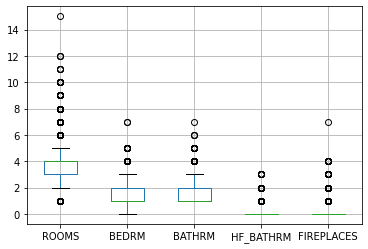

In [31]:
boxplot = master4.boxplot(column=['ROOMS', 'BEDRM', 'BATHRM', 'HF_BATHRM', 'FIREPLACES'])

In [32]:
master5 = master4[(master4['ROOMS'] <= 7) & (master4['BEDRM'] <= 5) & (master4['BATHRM'] <= 5) &
                  (master4['HF_BATHRM'] <= 2) & (master4['FIREPLACES'] <= 2)]

print(len(master5))
master5.describe()

42861


,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,FIREPLACES,Last_Sale_Price,Living_SqFt,LATITUDE,LONGITUDE,ACTIVE_RES_OCCUPANCY_COUNT,ZIPCODE,APPRAISED_VALUE_CURRENT_TOTAL,LAND_USE_CODE,LAST_SALE_PRICE,OTR_NEIGHBORHOOD_CODE,TAXRATE
count,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000,42861.000000
mean,1961.513684,1962.823523,3.697277,1.457922,1.396864,0.144210,0.137071,1500903.953221,871.298173,38.911537,-77.027959,79.743426,20011.286228,502797.621684,16.537085,1501142.938826,28.641702,0.850000
std,40.885871,38.451382,0.980529,0.768539,0.553767,0.353756,0.357628,11831574.331503,377.181516,0.023817,0.030075,102.129785,10.113703,295815.522507,1.287583,11831572.989491,14.208333,0.000000
min,1780.000000,1820.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.000000,199.000000,38.822270,-77.102180,0.000000,20001.000000,41830.000000,16.000000,1.000000,1.000000,0.850000
25%,1926.000000,1925.000000,3.000000,1.000000,1.000000,0.000000,0.000000,292000.000000,618.000000,38.901536,-77.045075,8.000000,20003.000000,325270.000000,16.000000,292000.000000,15.000000,0.850000
50%,1960.000000,1960.000000,4.000000,1.000000,1.000000,0.000000,0.000000,429752.000000,777.000000,38.911738,-77.029998,35.000000,20009.000000,452660.000000,17.000000,429900.000000,31.000000,0.850000
75%,2005.000000,2005.000000,4.000000,2.000000,2.000000,0.000000,0.000000,615000.000000,1036.000000,38.926224,-77.015716,127.000000,20016.000000,620230.000000,17.000000,615000.000000,40.000000,0.850000
max,2022.000000,2022.000000,7.000000,5.000000,5.000000,2.000000,2.000000,165989461.000000,5191.000000,38.983196,-76.913937,623.000000,20037.000000,7158600.000000,117.000000,165989461.000000,73.000000,0.850000


A quick search on Redfin for some of the properties with 5+ rooms shows they're real, but they're not what I envisioned when I formulated this project question. My idea of what is a condo is clearly different than the legal definition. Since I don't have the time to manually search every such unit, I'll have to choose cutoff points that I think will capture my research question without being too limiting to be unable to generalize.

In [33]:
print('5 rooms: ', len(master5.loc[master5['ROOMS'] == 5]) / len(master5))
print('6 rooms: ', len(master5.loc[master5['ROOMS'] == 6]) / len(master5))
print('7 rooms: ', len(master5.loc[master5['ROOMS'] == 7]) / len(master5))
print('3 bedrooms: ', len(master5.loc[master5['BEDRM'] == 3]) / len(master5))
print('4 bedrooms: ', len(master5.loc[master5['BEDRM'] == 4]) / len(master5))
print('5 bedrooms: ', len(master5.loc[master5['BEDRM'] == 5]) / len(master5))
print('3 bathrooms: ', len(master5.loc[master5['BATHRM'] == 3]) / len(master5))
print('4 bathrooms: ', len(master5.loc[master5['BATHRM'] == 4]) / len(master5))
print('5 bathrooms: ', len(master5.loc[master5['BATHRM'] == 5]) / len(master5))
print('1 half bath: ', len(master5.loc[master5['HF_BATHRM'] == 1]) / len(master5))
print('2 half baths: ', len(master5.loc[master5['HF_BATHRM'] == 2]) / len(master5))
print('1 fireplace: ', len(master5.loc[master5['FIREPLACES'] == 1]) / len(master5))
print('2 fireplaces: ', len(master5.loc[master5['FIREPLACES'] == 2]) / len(master5))

print(len(master5.loc[(master5['ROOMS'] > 6) | (master5['BEDRM'] > 3) | (master5['BATHRM'] > 3)]) / len(master5))
print(len(master5.loc[(master5['ROOMS'] > 5) | (master5['BEDRM'] > 2) | (master5['BATHRM'] > 2)]) / len(master5))

5 rooms:  0.13996406990037563
6 rooms:  0.03476353794825132
7 rooms:  0.005879470847623714
3 bedrooms:  0.06626070320337836
4 bedrooms:  0.005786145913534449
5 bedrooms:  0.00025664356874547956
3 bathrooms:  0.029304029304029304
4 bathrooms:  0.0011665616761158163
5 bathrooms:  0.00013998740113389796
1 half bath:  0.1424838431207858
2 half baths:  0.000863255640325704
1 fireplace:  0.1274585287324141
2 fireplaces:  0.004806234105597163
0.00996243671402907
0.08679218870301673


Clearly 1 half bath and 1 fireplace are significant, however with <1% of more than 1 of either, I'll limit my database to having 1 halfbath and 1 fireplace. Moreover, it's unsurprising that 1 half-bath and 1 fireplace are seen as outliers since >85% of the rest of the sample has 0 of both, but that doesn't mean we should get rid of the units that do have 1 or the other. When I first moved to the DC area, I was in an apartment with 1 bath and 1 half-bath, I know they exist!   

Looking at rooms, bedrooms, and bathrooms, 3% of units have 6 rooms, 6% of units have 3 bedrooms, and 3% of units have 3 bathrooms. 8% of my sample has *either* 6 rooms, 3 bedrooms, or 3 bathrooms, while under 1% of my sample has *either* greater than 6 rooms, or greater than 3 bedrooms, or greater than 3 bathrooms. I will make 6 rooms, 3 bedrooms, and 3 bathrooms be my cutoff point, remove outliers, and then examine price. I'll be using the rule of thumb that outliers are those units whose price is 1.5 x IQR greater than Q3 or 1.5 x IQR less than Q1.

In [34]:
master6 = master5[(master5['ROOMS'] <= 6) & (master5['BEDRM'] <= 3) & (master5['BATHRM'] <= 3) &
                  (master5['HF_BATHRM'] <= 1) & (master5['FIREPLACES'] <= 1)]
master6.describe()

,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,FIREPLACES,Last_Sale_Price,Living_SqFt,LATITUDE,LONGITUDE,ACTIVE_RES_OCCUPANCY_COUNT,ZIPCODE,APPRAISED_VALUE_CURRENT_TOTAL,LAND_USE_CODE,LAST_SALE_PRICE,OTR_NEIGHBORHOOD_CODE,TAXRATE
count,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000,42208.000000
mean,1961.775659,1963.048498,3.664755,1.434088,1.381634,0.138836,0.127677,1508367.163926,857.651891,38.911490,-77.027883,80.106686,20011.294423,494535.290300,16.541461,1508602.739220,28.617418,0.850000
std,40.773436,38.392105,0.939927,0.739489,0.534378,0.345780,0.333734,11922141.440208,352.221899,0.023883,0.030096,101.093722,10.124859,272630.490895,1.295889,11922140.417908,14.210465,0.000000
min,1780.000000,1820.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.000000,199.000000,38.822270,-77.102180,0.000000,20001.000000,41830.000000,16.000000,1.000000,1.000000,0.850000
25%,1927.000000,1925.000000,3.000000,1.000000,1.000000,0.000000,0.000000,290000.000000,616.000000,38.901521,-77.044955,9.000000,20003.000000,323020.000000,16.000000,290000.000000,15.000000,0.850000
50%,1962.000000,1960.000000,4.000000,1.000000,1.000000,0.000000,0.000000,425000.000000,771.000000,38.911718,-77.029995,36.000000,20009.000000,449135.000000,17.000000,425000.000000,31.000000,0.850000
75%,2005.000000,2005.000000,4.000000,2.000000,2.000000,0.000000,0.000000,605000.000000,1021.000000,38.926185,-77.015700,127.000000,20016.000000,613552.500000,17.000000,605500.000000,40.000000,0.850000
max,2022.000000,2022.000000,6.000000,3.000000,3.000000,1.000000,1.000000,165989461.000000,4515.000000,38.983196,-76.913937,623.000000,20037.000000,4810910.000000,117.000000,165989461.000000,73.000000,0.850000


In [35]:
q75, q25 = np.percentile(master6['APPRAISED_VALUE_CURRENT_TOTAL'], [75 ,25])
iqr = q75 - q25
outlier_cutoff = 1.5*iqr
outlier_cutoff + q75

1049351.25

We see immediately that there are no lower outliers since the IQR > Q1, so we'll just look at the higher ones.

In [36]:
high_outlier_price = q75 + outlier_cutoff
prop_high_outlier = str(round((len(master6.loc[(master6['APPRAISED_VALUE_CURRENT_TOTAL'] > 
                                     high_outlier_price)]) / len(master6) * 100), 3))
num_high_outlier = len(master6.loc[(master6['APPRAISED_VALUE_CURRENT_TOTAL'] > high_outlier_price)])
print('Number of outliers: ', num_high_outlier, '(' + prop_high_outlier + '%)')
non_outliers = master6.loc[(master6['APPRAISED_VALUE_CURRENT_TOTAL'] < high_outlier_price)] 
outliers = master6.loc[(master6['APPRAISED_VALUE_CURRENT_TOTAL'] > high_outlier_price)]
outliers.head()

Number of outliers:  1319 (3.125%)


,SSL_condo,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,HEAT,AC,FIREPLACES,Last_Sale_Price,Living_SqFt,Address,ASSESSMENT_NBHD,ENTRANCETYPE,WARD,LATITUDE,LONGITUDE,QUADRANT,VOTE_PRCNCT,CENSUS_BLOCK,CENSUS_BLOCKGROUP,RES_TYPE,ACTIVE_RES_OCCUPANCY_COUNT,ANC_2002,SMD_2002,ANC_2012,WARD_2002,WARD_2012,ANC_2023,SMD_2023,ZIPCODE,APPRAISED_VALUE_CURRENT_TOTAL,LAND_USE_CODE,OTR_NEIGHBORHOOD_NAME,LAST_SALE_PRICE,LAND_USE_DESCRIPTION,OTR_NEIGHBORHOOD_CODE,OTR_NEIGHBORHOOD_NAME,TAXRATE
0,0025 2292,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,1270000.000000,1496,2425 L STREET NW Unit 906 Washington DC,Central-tri 1,OFFICIAL,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000,1284770.000000,17.000000,Central,1270000.000000,Residential-Condo-Vertical,10.000000,Central,0.850000
1,0025 2293,2006.000000,2006,5.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,1292250.000000,1641,2425 L STREET NW Unit 907 Washington DC,Central-tri 1,OFFICIAL,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000,1361430.000000,17.000000,Central,1292250.000000,Residential-Condo-Vertical,10.000000,Central,0.850000
2,0025 2294,2006.000000,2006,4.000000,2.000000,2.000000,0.000000,8.000000,Y,0.000000,1400000.000000,1152,2425 L STREET NW Unit 908 Washington DC,Central-tri 1,OFFICIAL,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000,1091980.000000,17.000000,Central,1400000.000000,Residential-Condo-Vertical,10.000000,Central,0.850000
13,0025 2305,2006.000000,2006,5.000000,2.000000,2.000000,1.000000,8.000000,Y,0.000000,1376600.000000,1915,2425 L STREET NW Unit 240 Washington DC,Central-tri 1,OFFICIAL,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000,1348900.000000,17.000000,Central,1376600.000000,Residential-Condo-Vertical,10.000000,Central,0.850000
26,0025 2318,2006.000000,2006,5.000000,2.000000,2.000000,1.000000,1.000000,Y,0.000000,1790000.000000,1864,2425 L STREET NW Unit 340 Washington DC,Central-tri 1,OFFICIAL,Ward 2,38.904239,-77.052353,NW,Precinct 4,005503 1003,005503 1,RESIDENTIAL,225.000000,ANC 2A,SMD 2A02,ANC 2A,Ward 2,Ward 2,ANC 2A,SMD 2A02,20037.000000,1388990.000000,17.000000,Central,1790000.000000,Residential-Condo-Vertical,10.000000,Central,0.850000


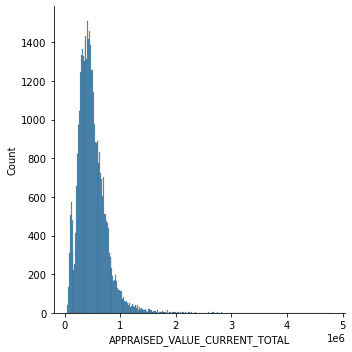

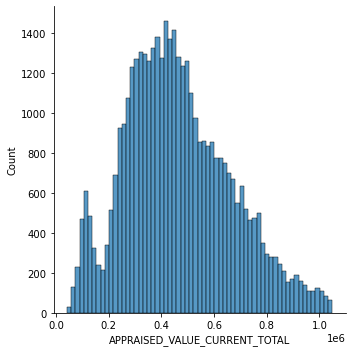

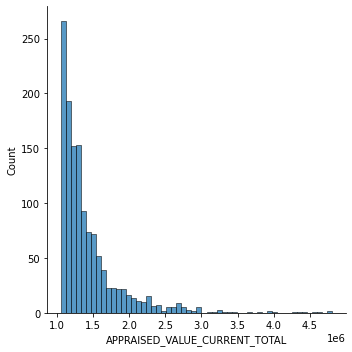

In [37]:
sns.displot(master6, x="APPRAISED_VALUE_CURRENT_TOTAL")
sns.displot(non_outliers, x="APPRAISED_VALUE_CURRENT_TOTAL")
sns.displot(outliers, x="APPRAISED_VALUE_CURRENT_TOTAL")

3.125% of the dataset is outliers, with the non-outliers roughly normally distributed with a right skew, which is what we'd expect for housing pricing! I will remove the price outliers then the dataset is ready for EDA, final cleaning, and analysis.

## Part 2b: Data preprocessing and EDA

In [38]:
master7 = non_outliers[['SSL_condo','Actual_Year_Built','Effective_Year_Built','ROOMS','BEDRM','BATHRM','HF_BATHRM',
                   'HEAT','AC','FIREPLACES','Living_SqFt','WARD','ZIPCODE','LATITUDE','LONGITUDE','QUADRANT',
                   'RES_TYPE','APPRAISED_VALUE_CURRENT_TOTAL']]
master7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40889 entries, 3 to 59483
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   SSL_condo                      40889 non-null  object  
 1   Actual_Year_Built              40889 non-null  float64 
 2   Effective_Year_Built           40889 non-null  int64   
 3   ROOMS                          40889 non-null  float64 
 4   BEDRM                          40889 non-null  float64 
 5   BATHRM                         40889 non-null  float64 
 6   HF_BATHRM                      40889 non-null  float64 
 7   HEAT                           40889 non-null  category
 8   AC                             40889 non-null  object  
 9   FIREPLACES                     40889 non-null  float64 
 10  Living_SqFt                    40889 non-null  int64   
 11  WARD                           40889 non-null  object  
 12  ZIPCODE                        4

In [39]:
master7['Actual_Year_Built'] = master7['Actual_Year_Built'].astype(int)
master7['ROOMS'] = master7['ROOMS'].astype(int)
master7['BEDRM'] = master7['BEDRM'].astype(int)
master7['BATHRM'] = master7['BATHRM'].astype(int)
master7['HF_BATHRM'] = master7['HF_BATHRM'].astype(int)
master7['AC'] = master7['AC'].map({'Y': 1, 'N': 0})
master7['FIREPLACES'] = master7['FIREPLACES'].astype(int)
#master7['WARD'] = master7['WARD'].astype("category")


<ipython-input-39-db43a7f6871c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master7['Actual_Year_Built'] = master7['Actual_Year_Built'].astype(int)
<ipython-input-39-db43a7f6871c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master7['ROOMS'] = master7['ROOMS'].astype(int)
<ipython-input-39-db43a7f6871c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [60]:
print(len(master7))
master7['WARD'].value_counts()
master7.corr()

40872


,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,AC,FIREPLACES,Living_SqFt,ZIPCODE,LATITUDE,LONGITUDE,APPRAISED_VALUE_CURRENT_TOTAL
Actual_Year_Built,1.000000,0.948899,-0.020407,-0.029005,0.055753,0.025204,0.159893,-0.169931,0.069278,-0.040204,-0.137927,0.077828,0.128433
Effective_Year_Built,0.948899,1.000000,-0.010417,-0.007635,0.083157,0.038946,0.177518,-0.190734,0.088846,-0.072421,-0.141345,0.103802,0.157913
ROOMS,-0.020407,-0.010417,1.000000,0.817531,0.602524,0.322591,0.045306,0.157385,0.744044,-0.136310,0.039056,0.085126,0.522244
BEDRM,-0.029005,-0.007635,0.817531,1.000000,0.687009,0.279416,0.083702,0.123440,0.727251,-0.154114,0.021609,0.200099,0.514944
BATHRM,0.055753,0.083157,0.602524,0.687009,1.000000,0.212152,0.116958,0.112869,0.701535,-0.177607,0.116499,0.057370,0.651717
HF_BATHRM,0.025204,0.038946,0.322591,0.279416,0.212152,1.000000,0.071073,0.149585,0.439039,-0.062851,0.053433,-0.004895,0.357950
AC,0.159893,0.177518,0.045306,0.083702,0.116958,0.071073,1.000000,0.062411,0.076888,0.025966,-0.082284,0.131892,0.126547
FIREPLACES,-0.169931,-0.190734,0.157385,0.123440,0.112869,0.149585,0.062411,1.000000,0.152433,-0.034227,0.024513,-0.080533,0.219895
Living_SqFt,0.069278,0.088846,0.744044,0.727251,0.701535,0.439039,0.076888,0.152433,1.000000,-0.143597,0.085993,-0.023870,0.727950
ZIPCODE,-0.040204,-0.072421,-0.136310,-0.154114,-0.177607,-0.062851,0.025966,-0.034227,-0.143597,1.000000,-0.199611,-0.114651,-0.280065


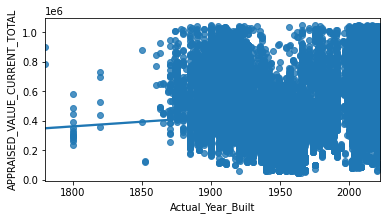

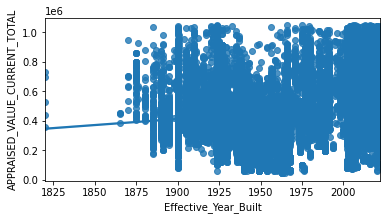

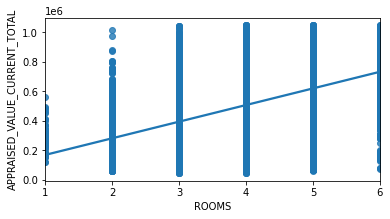

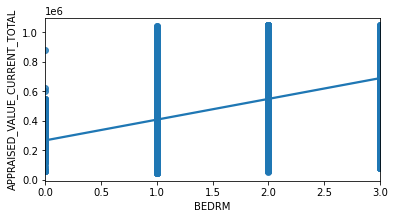

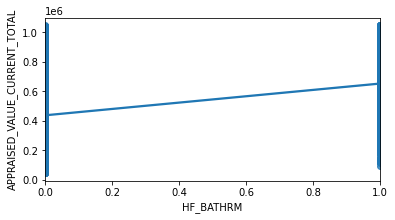

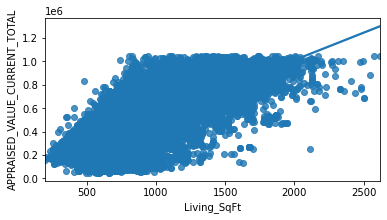

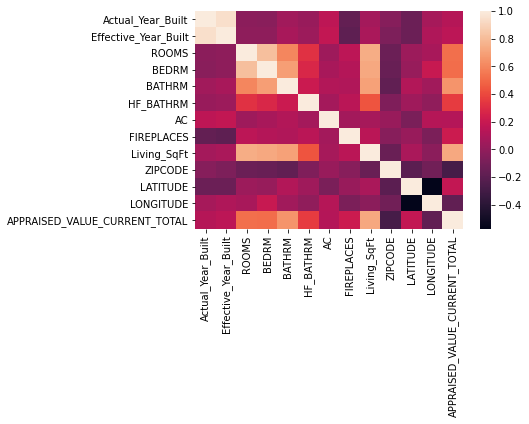

In [40]:
plotfeats = ["Actual_Year_Built","Effective_Year_Built","ROOMS","BEDRM","HF_BATHRM","Living_SqFt"]

for f in plotfeats:
    ax=plt.subplots(figsize=(6,3))
    ax=sns.regplot(x=master7[f], y=master7['APPRAISED_VALUE_CURRENT_TOTAL'])
    plt.show()
sns.heatmap(master7.corr())

Plotting each of the non-categorical variables against appraised price, it's very difficult to discern anything. However, there appears to be a positive correlation with all variables and price. Note as well there there is high correlation between many of the variables, indicating multicollinearity. Below are the actual correlation coefficients.

In [1]:
master7.corr()

NameError: name 'master7' is not defined

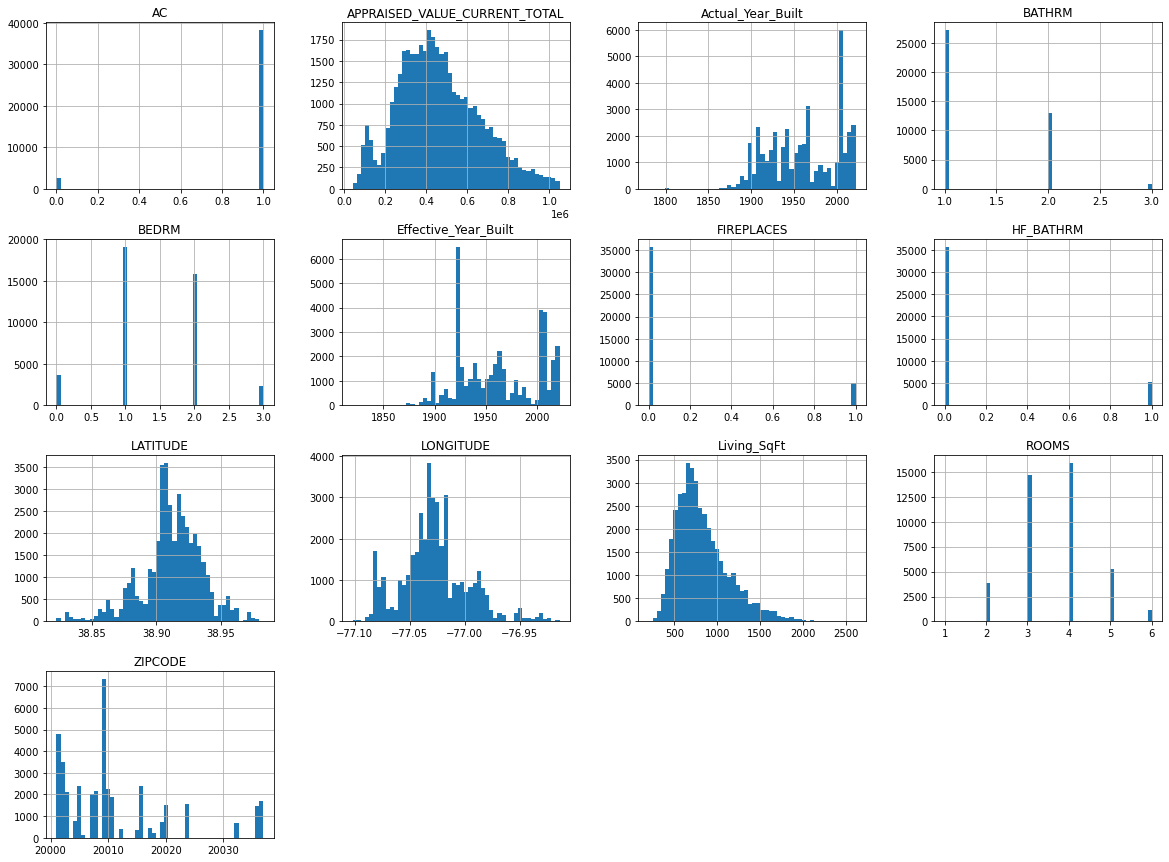

In [41]:
master7.hist(bins=50, figsize=(20,15))
plt.show()

QUADRANT
NW    30067
SE     4711
NE     4449
SW     1662
Name: QUADRANT, dtype: int64


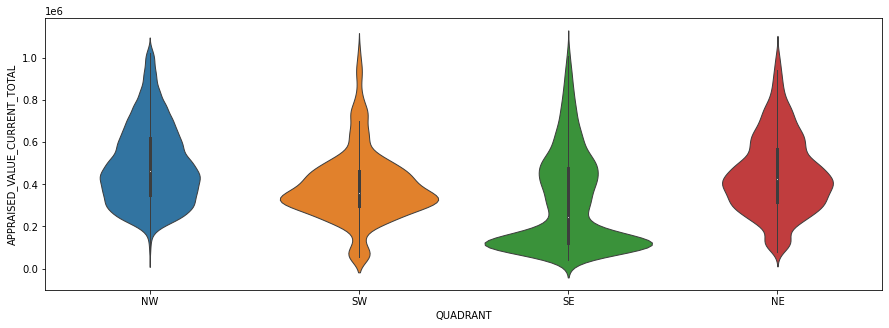

ZIPCODE
20009.000000    7318
20001.000000    4810
20002.000000    3489
20016.000000    2410
20005.000000    2386
20010.000000    2244
20008.000000    2179
20003.000000    2110
20007.000000    2013
20011.000000    1883
20037.000000    1695
20024.000000    1565
20020.000000    1520
20036.000000    1489
20004.000000     782
20019.000000     736
20032.000000     698
20017.000000     445
20012.000000     399
20015.000000     357
20018.000000     216
20006.000000     145
Name: ZIPCODE, dtype: int64


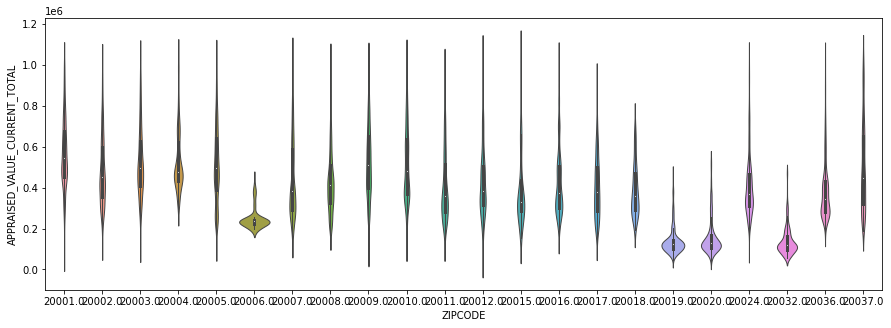

RES_TYPE
RESIDENTIAL        39836
MIXED USE           1028
NON RESIDENTIAL       25
Name: RES_TYPE, dtype: int64


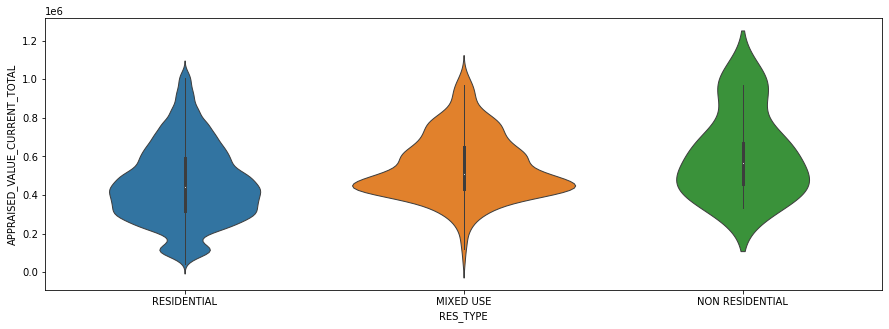

HEAT
1.000000     18814
8.000000     16104
7.000000      2409
13.000000     2184
3.000000       626
0.000000       256
5.000000       187
6.000000       177
4.000000        53
2.000000        31
12.000000       27
9.000000         9
11.000000        7
10.000000        5
Name: HEAT, dtype: int64


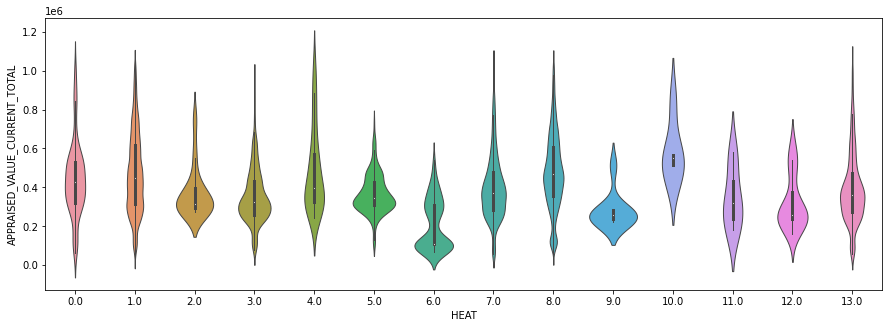

In [42]:
catfeat= ["WARD", "QUADRANT", "ZIPCODE", 'RES_TYPE', "HEAT"]
catdata = master7.loc[:, catfeat]
cat_values = {}

for n in catfeat[1:len(catfeat)]:
    print(n)
    print(pd.value_counts(catdata[n]))
    ax = plt.subplots(figsize=(15, 5))
    plt.xticks(rotation='horizontal')
    ax=sns.violinplot(x=n, y="APPRAISED_VALUE_CURRENT_TOTAL", data=master7, linewidth=1)
    plt.show()

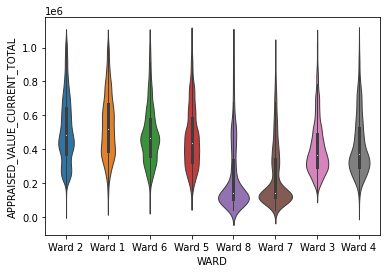

In [43]:
ax=sns.violinplot(x="WARD", y="APPRAISED_VALUE_CURRENT_TOTAL", data=master7, linewidth=1)
plt.show()

Some of the categorical variables show promise as being correlated with price.

In [2]:
master7.plot(kind="scatter", x="LONGITUDE", y="LATITUDE", alpha=0.4, figsize=(12,12),
            c="WARD", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.legend()

NameError: name 'master7' is not defined

In [45]:
master7.to_csv('condos.csv', index=False)

# Part 3: Test/Train split, model testing

Now that the data is ready, time to split it into train/test and run it through some models. I will use the model with the lowest root mean square error (RMSE) of the test prediction as the best model for future work.

In [46]:
from sklearn.model_selection import train_test_split
#master7 = master7.reset_index()
master7.dropna(inplace=True)

encoded_df = pd.get_dummies(data = master7, columns = catfeat)
x_data = encoded_df.drop(['SSL_condo','APPRAISED_VALUE_CURRENT_TOTAL'], axis = 1)
y_data = encoded_df['APPRAISED_VALUE_CURRENT_TOTAL']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.20, random_state=679)
encoded_df.head()

<ipython-input-46-072dd47eeaca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master7.dropna(inplace=True)


,SSL_condo,Actual_Year_Built,Effective_Year_Built,ROOMS,BEDRM,BATHRM,HF_BATHRM,AC,FIREPLACES,Living_SqFt,LATITUDE,LONGITUDE,APPRAISED_VALUE_CURRENT_TOTAL,WARD_Ward 1,WARD_Ward 2,WARD_Ward 3,WARD_Ward 4,WARD_Ward 5,WARD_Ward 6,WARD_Ward 7,WARD_Ward 8,QUADRANT_NE,QUADRANT_NW,QUADRANT_SE,QUADRANT_SW,ZIPCODE_20001.0,ZIPCODE_20002.0,ZIPCODE_20003.0,ZIPCODE_20004.0,ZIPCODE_20005.0,ZIPCODE_20006.0,ZIPCODE_20007.0,ZIPCODE_20008.0,ZIPCODE_20009.0,ZIPCODE_20010.0,ZIPCODE_20011.0,ZIPCODE_20012.0,ZIPCODE_20015.0,ZIPCODE_20016.0,ZIPCODE_20017.0,ZIPCODE_20018.0,ZIPCODE_20019.0,ZIPCODE_20020.0,ZIPCODE_20024.0,ZIPCODE_20032.0,ZIPCODE_20036.0,ZIPCODE_20037.0,RES_TYPE_MIXED USE,RES_TYPE_NON RESIDENTIAL,RES_TYPE_RESIDENTIAL,HEAT_0.0,HEAT_1.0,HEAT_2.0,HEAT_3.0,HEAT_4.0,HEAT_5.0,HEAT_6.0,HEAT_7.0,HEAT_8.0,HEAT_9.0,HEAT_10.0,HEAT_11.0,HEAT_12.0,HEAT_13.0
3,0025 2295,2006,2006,4,1,2,0,1.000000,0,1161,38.904239,-77.052353,919910.000000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0025 2296,2006,2006,4,2,2,0,1.000000,0,1047,38.904239,-77.052353,847580.000000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,0025 2297,2006,2006,4,2,2,0,1.000000,0,1291,38.904239,-77.052353,970460.000000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,0025 2298,2006,2006,4,1,1,0,1.000000,0,805,38.904239,-77.052353,678120.000000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,0025 2300,2006,2006,3,1,1,0,1.000000,0,750,38.904239,-77.052353,601160.000000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
